In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as datetime
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

In [2]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})


# Ajustes en los archivos antes de procesar

In [3]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

In [4]:
# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)


Timestamp('2018-04-02 20:43:21.574816')

# Empieza el analisis

In [5]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [6]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [7]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [8]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [9]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [10]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,41.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


## Ver postulaciones de secundario en curso y vistas hechas al respecto (vistas, postulaciones, área de trabajo).


In [41]:
postulantes_sec = postulantes.loc[(postulantes['nombre'] == 'Secundario') & (postulantes['estado'] == 'En Curso')]
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0


In [42]:
#postulantes_1 = postulantes_sec[postulantes_sec.isna().any(axis=1)]
#null_columns=postulantes_sec.columns[postulantes_sec.isnull().any()]
#print(postulantes_sec[postulantes_sec.isnull().any(axis=1)][null_columns].head())
#aa = postulantes_sec.dropna(axis=0)

In [109]:
#pd.to_datetime(postulantes_sec['fechapostulacion'])
#postulantes_sec['edad'] = (now - pd.to_datetime(postulantes_sec['fechanacimiento'])).astype('<m8[Y]')
#dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_sec = postulantes_sec.loc[(postulantes_sec['edad'] >= 18) & (postulantes_sec['edad'] <= 65)]
#postulantes_sec.sort_values('age')
#veo el promedio de edad que utilizan la pagina y poseen secundario en curso
pd.to_numeric(postulantes_sec['edad'])

54977    41.0
54978    42.0
54979    32.0
54980    32.0
54981    34.0
54982    41.0
54983    35.0
54984    37.0
54985    36.0
54986    42.0
54987    33.0
54988    34.0
54989    42.0
54990    30.0
54991    40.0
54992    56.0
54993    31.0
54994    47.0
54995    31.0
54996    31.0
54997    33.0
54998    32.0
54999    30.0
55000    49.0
55001    37.0
55002    38.0
55003    28.0
55004    37.0
55005    33.0
55006    28.0
         ... 
58341    18.0
58342    30.0
58344    18.0
58345    18.0
58346    19.0
58347    21.0
58348    22.0
58349    36.0
58350    22.0
58351    37.0
58352    19.0
58353    19.0
58354    19.0
58355    19.0
58356    22.0
58357    18.0
58358    21.0
58360    21.0
58361    19.0
58362    18.0
58363    27.0
58364    18.0
58365    20.0
58366    19.0
58367    27.0
58368    18.0
58369    18.0
58370    22.0
58371    18.0
58372    19.0
Name: edad, Length: 3250, dtype: float64

In [110]:
#obtengo las decadas correspondientes para agrupar
postulantes_sec['decil'] = np.floor( postulantes_sec['edad'].apply(lambda x: x /10) )
postulantes_sec['decil'] = postulantes_sec['decil'].apply(lambda x: x*10)
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad,decil
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0,40.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0,40.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0,30.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0,30.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0,30.0


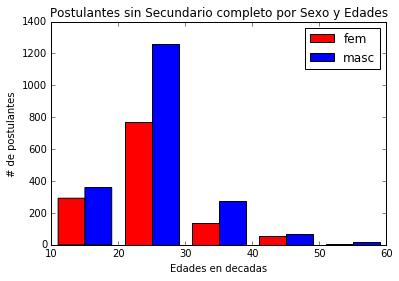

In [111]:
#diferencio entre mujeres y hombres
sec_fem = postulantes_sec.loc[postulantes_sec['sexo'] == 'FEM']
sec_masc = postulantes_sec.loc[postulantes_sec['sexo'] == 'MASC']
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes sin Secundario completo por Sexo y Edades')
plt.hist([sec_fem['decil'],sec_masc['decil']], bins=5, color=['red', 'blue'], label=['fem','masc'])
plt.legend()


In [135]:
#veo las postulaciones que han hecho los que no poseen secundario completo
mergeo_sec = pd.merge(postulaciones, postulantes_sec, on='idpostulante')
agrup_sec = mergeo_sec.groupby(['idaviso']).size().to_frame(name='count').reset_index()
agrup_sec.sort_values('count', ascending=False)
secs = pd.merge(mergeo_sec, agrup_sec, on='idaviso')
secs.sort_values('count', ascending=False)

,idaviso,idpostulante,fechapostulacion,nombre,estado,valor_educacion,fechanacimiento,sexo,edad,decil,count
1239,1112280937,8MaXEdj,2018-01-23 12:39:40,Secundario,En Curso,5,1992-08-04,FEM,25.0,20.0,334
1547,1112280937,5mlpXPk,2018-01-26 00:53:05,Secundario,En Curso,5,1995-09-08,FEM,22.0,20.0,334
1549,1112280937,qe6wNON,2018-01-24 10:10:08,Secundario,En Curso,5,1996-07-02,MASC,21.0,20.0,334
1550,1112280937,4rNKDAq,2018-02-28 20:13:06,Secundario,En Curso,5,1998-11-22,FEM,19.0,10.0,334
1551,1112280937,LNKRxLj,2018-02-16 05:41:05,Secundario,En Curso,5,1998-06-19,MASC,19.0,10.0,334
1552,1112280937,vVjlWB1,2018-02-27 20:00:12,Secundario,En Curso,5,1979-10-10,FEM,38.0,30.0,334
1553,1112280937,Bm5GWpZ,2018-01-24 06:33:05,Secundario,En Curso,5,1995-02-01,FEM,23.0,20.0,334
1554,1112280937,bOjYk3b,2018-01-29 19:09:53,Secundario,En Curso,5,1991-11-12,MASC,26.0,20.0,334
1555,1112280937,DrXEj35,2018-02-28 02:02:27,Secundario,En Curso,5,1998-08-09,MASC,19.0,10.0,334
1556,1112280937,GNZqJOK,2018-02-28 17:52:14,Secundario,En Curso,5,1988-12-05,FEM,29.0,20.0,334
